[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sunyeul/playground/blob/main/Attention_based_random_forest/Attention_based_Random_Forest.ipynb)

In [1]:
!pip install --upgrade ortools --quiet

     |████████████████████████████████| 15.5 MB 4.3 MB/s 
     |████████████████████████████████| 1.0 MB 63.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [414]:
import pandas as pd
import numpy as np

import torch
from torch import optim
from torch import nn

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_california_housing, load_diabetes, make_friedman3
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from dataclasses import dataclass
from typing import List, Dict, Callable
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from ortools.linear_solver import pywraplp

In [415]:
def predict_per_tree(self, X: pd.DataFrame) -> np.ndarray:
    predict_matrix = []

    for i, estimator in enumerate(self.estimators_):
        predict_matrix.append(
            estimator.predict(X.to_numpy())
        )
    return np.array(predict_matrix).T

RandomForestRegressor.predict_per_tree = predict_per_tree

In [416]:
def predict_with_attention(self, X, alpha) -> np.array:
    y_pred_per_tree = self.predict_per_tree(X)
    y_pred_attention = np.sum(y_pred_per_tree * alpha, axis=1)

    return y_pred_attention

RandomForestRegressor.predict_with_attention = predict_with_attention

In [417]:
@dataclass(frozen=True)
class LeafNode:
    node_size: int
    mean_feature_vector: np.ndarray
    mean_target_value: float
    std_target_value: float

def fit_leaf_nodes(
    self,
    X: pd.DataFrame,
    y: pd.Series
):

    self.leaf_nodes_ = []

    for estimator in self.estimators_:
        leaf_nos = estimator.apply(X.to_numpy())

        leaf_nodes = {}
        for leaf_no in np.unique(leaf_nos):
            leaf_node_size = np.sum(leaf_nos == leaf_no)
            mean_feature_vector = X[leaf_nos == leaf_no].mean().to_numpy()
            mean_target_value = y[leaf_nos == leaf_no].mean()
            std_target_value = y[leaf_nos == leaf_no].std()

            leaf_nodes[leaf_no] = LeafNode(
                node_size=leaf_node_size, 
                mean_feature_vector=mean_feature_vector,
                mean_target_value=mean_target_value,
                std_target_value=std_target_value
            )

        self.leaf_nodes_.append(leaf_nodes)

RandomForestRegressor.fit_leaf_nodes = fit_leaf_nodes

In [418]:
def apply_dist_matrix(self, X: pd.DataFrame, metrics: Callable) -> np.ndarray:
    dist_matrix = []

    for i, (estimator, leaf_node) in enumerate(zip(self.estimators_, self.leaf_nodes_)):
        leaf_nos = estimator.apply(X.to_numpy())

        mean_feature_vectors = np.array([leaf_node[leaf_no].mean_feature_vector for leaf_no in leaf_nos])
        dist_column = metrics(X=X.to_numpy(), Y=mean_feature_vectors)
        dist_matrix.append(dist_column)
    return np.array(dist_matrix).T

RandomForestRegressor.apply_dist_matrix = apply_dist_matrix

In [419]:
def calc_l2_distance(X: np.ndarray, Y:np.ndarray) -> np.array:
    return np.sqrt(np.sum(np.square(X - Y), axis=1))

def softmax(dist_matrix: np.array, tau: float=1.0) -> np.array:
    max_dist = np.max(dist_matrix, axis=1).reshape(-1, 1)
    exp_dist_matrix = np.exp( (dist_matrix - max_dist) / (2 * tau) )
    exp_dist_matrix /= np.sum(exp_dist_matrix, axis=1).reshape(-1, 1)
    return exp_dist_matrix

def calc_attention_weights(dist_matrix, w, epsilon=0.5):
    alpha = (1 - epsilon) * dist_matrix + epsilon * w
    return alpha

In [420]:
X, y = load_diabetes(
    return_X_y=True,
    as_frame=True
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=.8,
    test_size=.2,
    shuffle=True,
    stratify=pd.cut(y, bins=5),
    random_state=3407
)

In [421]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=3,
    min_samples_leaf=10,
    random_state=3407,
    n_jobs=-1
)

rf.fit(
    X=X_train,
    y=y_train
)

rf.fit_leaf_nodes(
    X=X_train,
    y=y_train
)

# Linear Programming

In [422]:
n = X_train.shape[0]
T = rf.n_estimators
epsilon = .5
tau = 1.

In [423]:
l2_dist_matrix = rf.apply_dist_matrix(X=X_train, metrics=calc_l2_distance)
softmax_l2_dist_matrix = softmax(dist_matrix=l2_dist_matrix, tau=tau)

y_pred_per_tree = rf.predict_per_tree(X_train)

q = [y_train.to_numpy()[i] - (1 - epsilon) * np.sum(y_pred_per_tree[i] * softmax_l2_dist_matrix[i]) for i in range(n)]

In [424]:
# [START program]

# [START solver]
# Create the linear solver with the GLOP backend.
solver = pywraplp.Solver.CreateSolver('GLOP')
# [END solver]

# [START variables]
infinity = solver.infinity()

# Create the variables w and g.
w = [solver.NumVar(0.0, infinity, f'w{k}') for k in range(T)]
g = [solver.NumVar(0.0, infinity, f'g{i}') for i in range(n)]

assert solver.NumVariables() == n+T
print('Number of variables =', solver.NumVariables())
# [END variables]

# [START constraints]
# w_k >= 0
# [solver.Add(w[k] >= 0) for k in range(T)]

# sum_{k} w_{k} = 1
solver.Add(np.sum(w) ==1)

# g_i >= q_i - epsilon * sum(y_pred_i_k * w_k)
[solver.Add(g[i] >= q[i] -  epsilon * np.sum([y_pred_per_tree[i] * w])) for i in range(n)]

# g_i >= -q_i + epsilon * sum(y_pred_i_k * w_k)
[solver.Add(g[i] >= -q[i] + epsilon * np.sum([y_pred_per_tree[i] * w])) for i in range(n)]

assert solver.NumConstraints() == 2 * n + 1
print('Number of constraints =', solver.NumConstraints())
# [END constraints]

# [START objective]
# Minimize sum_{i} g_i.
solver.Minimize(np.sum([g[i] for i in range(n)]))
# [END objective]

# [START solve]
status = solver.Solve()
# [END solve]

# [START print_solution]
if status == pywraplp.Solver.OPTIMAL:
    print('Solution:')
    print('Objective value =', solver.Objective().Value())
    for k in range(T):
        print(f'w{k} =', w[k].solution_value())
    # for i in range(n):
    #     print(f'g{i} =', g[i].solution_value())
else:
    print('The problem does not have an optimal solution.')
# [END print_solution]

# [START advanced]
print('\nAdvanced usage:')
print('Problem solved in %f milliseconds' % solver.wall_time())
print('Problem solved in %d iterations' % solver.iterations())
# [END advanced]
# [END program]

Number of variables = 453
Number of constraints = 707
Solution:
Objective value = 13670.978606141272
w0 = 0.0
w1 = 0.29737461387388636
w2 = 0.008642225702770113
w3 = 0.0
w4 = 0.0
w5 = 0.0
w6 = 0.0
w7 = 0.0
w8 = 0.0
w9 = 0.0
w10 = 0.0
w11 = 0.0
w12 = 0.0
w13 = 0.022374719151973012
w14 = 0.0
w15 = 0.0
w16 = 0.0
w17 = 0.0
w18 = 0.0
w19 = 0.0
w20 = 0.0
w21 = 0.0
w22 = 0.0
w23 = 0.0
w24 = 0.0
w25 = 0.0
w26 = 0.0
w27 = 0.0
w28 = 0.0
w29 = 0.008763510048186646
w30 = 0.0
w31 = 0.0
w32 = 0.0
w33 = 0.0
w34 = 0.0
w35 = 0.0
w36 = 0.0
w37 = 0.0
w38 = 0.0
w39 = 0.0
w40 = 0.0
w41 = 0.0
w42 = 0.0
w43 = 0.0
w44 = 0.0
w45 = 0.0
w46 = 0.0
w47 = 0.0
w48 = 0.0
w49 = 0.0
w50 = 0.0
w51 = 0.0
w52 = 0.0
w53 = 0.0
w54 = 0.0
w55 = 0.0
w56 = 0.0
w57 = 0.0
w58 = 0.0
w59 = 0.24076775601194914
w60 = 0.0
w61 = 0.0
w62 = 0.0
w63 = 0.0
w64 = 0.0
w65 = 0.0
w66 = 0.0
w67 = 0.0
w68 = 0.0
w69 = 0.0
w70 = 0.0
w71 = 0.0
w72 = 0.0
w73 = 0.0
w74 = 0.0
w75 = 0.0
w76 = 0.0
w77 = 0.0
w78 = 0.0
w79 = 0.0
w80 = 0.0
w81 = 0.35846064

In [425]:
np.sum([w[k].solution_value() > 0 for k in range(T)])

7

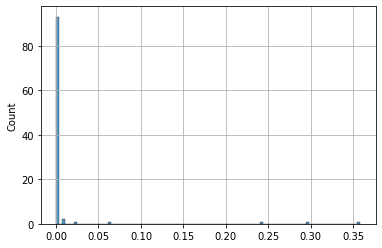

In [426]:
sns.histplot([w[k].solution_value() for k in range(T)], bins=100)

plt.grid(True)
plt.show()

In [427]:
l2_dist_matrix = rf.apply_dist_matrix(X=X_train, metrics=calc_l2_distance)
softmax_l2_dist_matrix = softmax(l2_dist_matrix, tau=tau)

alpha_train = calc_attention_weights(
    dist_matrix=softmax_l2_dist_matrix, 
    w=np.array([w[k].solution_value() for k in range(T)]),
    epsilon=epsilon
)

y_attention_based_pred = rf.predict_with_attention(X=X_train, alpha=alpha_train)

In [428]:
np.mean(np.abs(y_train - y_attention_based_pred)), np.mean(np.abs(y_train - rf.predict(X_train)))

(38.72798471994698, 39.855171612156596)

In [429]:
np.mean(np.square(y_train - y_attention_based_pred)), np.mean(np.square(y_train - rf.predict(X_train)))

(2314.8538928106504, 2381.121875035181)

In [430]:
r2_score(y_train, y_attention_based_pred), r2_score(y_train, rf.predict(X_train))

(0.6082281453742983, 0.5970127808197409)

In [431]:
l2_dist_matrix = rf.apply_dist_matrix(X=X_test, metrics=calc_l2_distance)
softmax_l2_dist_matrix = softmax(l2_dist_matrix, tau=tau)

alpha_test = calc_attention_weights(
    dist_matrix=softmax_l2_dist_matrix, 
    w=np.array([w[k].solution_value() for k in range(T)]),
    epsilon=epsilon
)

y_attention_based_pred = rf.predict_with_attention(X=X_test, alpha=alpha_test)

In [432]:
np.mean(np.abs(y_test - y_attention_based_pred)), np.mean(np.abs(y_test - rf.predict(X_test)))

(52.361662032431006, 51.95173120047273)

In [433]:
np.mean(np.square(y_test - y_attention_based_pred)), np.mean(np.square(y_test - rf.predict(X_test)))

(4099.341497731503, 4035.7107180263165)

In [434]:
r2_score(y_test, y_attention_based_pred), r2_score(y_test, rf.predict(X_test))

(0.31820430604450056, 0.32878727202331304)

## Gradient Descent

In [ ]:
w = torch.tensor([.01 for _ in range(100)], requires_grad=True)

f_list = []

lr = 0.1
optimizer = optim.Adam([w], lr)

for i in tqdm(range(100)):
    optimizer.zero_grad()
    outputs = calc_attention_based_loss(w=w)
    outputs.backward()
    optimizer.step()
    f_list.append(outputs.item())

In [ ]:
sns.lineplot(data=f_list)

plt.grid(True)
plt.show()

In [ ]:
f_list[-1]